In [2]:
from nltk.corpus import semcor
import pandas as pd
import numpy as np
from semcor_bert_utils import *

## Creating a Dataframe of all the tags in SEMCOR

In [6]:
tagged_sents = nltk.corpus.semcor.tagged_sents(tag = 'sem')

In [7]:
sel = SemCorSelector()

In [8]:
tag_freqs = {}
for s in tagged_sents:
    for tok in s:
        if type(tok) == nltk.tree.Tree:
            if tok.label() in tag_freqs.keys():
                tag_freqs[tok.label()] += 1
            else:
                tag_freqs[tok.label()] = 1
    

In [9]:
freqs = pd.DataFrame(pd.Series(tag_freqs)).reset_index()
freqs.columns = ['lemma', 'count']
sorted_freqs = freqs.sort_values('count', ascending = False)
words = []
def get_word(lem):
    if type(lem) == nltk.corpus.reader.wordnet.Lemma:
        return lem.name()
    else:
        return lem.split('.')[0]
sorted_freqs['word'] = sorted_freqs['lemma'].apply(get_word)

In [10]:
def get_pos(lem):
    lem = str(lem)
    try:
        return lem.split('.')[1]
    except:
        return 'No POS'

def get_sense_num(lem):
    lem = str(lem)
    try:
        return lem.split('.')[2]
    except:
        return "No marked sense"

In [11]:
decomp_tags = []
for s in tagged_sents:
    for tok in s:
        if type(tok) == nltk.tree.Tree:
            lem = tok.label()
            decomp_tags.append({'lemma': lem, 'word': get_word(lem), 
                                'pos': get_pos(lem), 'sense': get_sense_num(lem)})
            
semcor_tags = pd.DataFrame(decomp_tags)

In [12]:
semcor_tags

,lemma,word,pos,sense
0,Lemma('group.n.01.group'),group,n,01
1,Lemma('state.v.01.say'),say,v,01
2,Lemma('friday.n.01.Friday'),Friday,n,01
3,Lemma('probe.n.01.investigation'),investigation,n,01
4,Lemma('atlanta.n.01.Atlanta'),Atlanta,n,01
...,...,...,...,...
235074,Lemma('be.v.01.be'),be,v,01
235075,Lemma('let.v.01.let'),let,v,01
235076,Lemma('make.v.01.make'),make,v,01
235077,turn_into.v.00,turn_into,v,00


In [15]:
semcor_tags.to_csv('data/semcor_tags.csv', index = False)

## Grouping & Aggregation for SD of Frequencies [Deprecated]

In [149]:
freqs_for_sense = semcor_tags.groupby(["word", 'pos',
                                       'sense']).agg('count').rename({'lemma': 'freq'}, axis = 1).reset_index()
sparsity = freqs_for_sense.groupby(['word', 'pos']).agg([np.std, 'count'])

In [164]:
sparsity[('freq', 'count')] = sparsity['freq']['count'].apply(lambda x: x - 1)
sparsity = sparsity[sparsity['freq']['count'] > 1]
sparsity = sparsity.sort_values([('freq', 'std')], ascending = False).reset_index()

In [165]:
sparsity.head()

word pos         freq      
                     std count
0    be   v  2753.646765     8
1  have   v   341.328009     6
2    do   v   214.057214     2
3  make   v   176.710568     8
4   see   v   128.110418    13

In [166]:
sparsity.columns = ['word', 'pos', 'freq_sd', 'senses_for_pos']

In [170]:
sparsity.to_csv('data/semcor_sparsity.csv', index = False)

## Filtering the Original Dataset

In [5]:
import pandas as pd

In [6]:
semcor_tags = pd.read_csv('data/semcor_tags.csv')

In [16]:
word_freqs = semcor_tags[['word', 'pos']].groupby('word').agg('count').rename({'pos':'freq'}, axis = 1)
above_10 = word_freqs[word_freqs['freq'] > 10]
above_10

,freq
word,
0,23
1,128
10,73
100,38
1000,19
...,...
yield,29
young,103
young_man,14


In [64]:
freq_tags = semcor_tags[semcor_tags['word'].isin(above_10.index)]
filtered_sense_freqs = freq_tags.groupby(['word', 'pos', 'sense']).agg('count').rename({'lemma': 'freq'},
                                                                axis = 1)
filtered_sense_freqs.sort_values('freq', ascending = False)

freq
word   pos sense       
be     v   01     11221
person n   01      6696
be     v   02      2996
say    v   01      1939
not    r   01      1703
...                 ...
heavy  s   0;1        1
solid  s   09         1
           10         1
           1;7        1
zero   s   03         1

[11287 rows x 1 columns]

In [65]:
filtered_sense_freqs = filtered_sense_freqs[filtered_sense_freqs['freq'] >= 10].reset_index()
filtered_sense_freqs = filtered_sense_freqs[['word','pos', 'sense', 'freq']]
filtered_sense_freqs

,word,pos,sense,freq
0,0,n,02,20
1,1,n,01,21
2,1,s,01,107
3,10,s,01,69
4,100,s,01,33
...,...,...,...,...
4090,yesterday,n,01,13
4091,yet,r,01,34
4092,young,a,01,95
4093,young_man,n,01,14


As there are 4,095 words with more than 10 occurrences per sense, we find the entropy of each word/POS pair.

In [75]:
filtered_sense_freqs

,word,pos,sense,freq
0,0,n,02,20
1,1,n,01,21
2,1,s,01,107
3,10,s,01,69
4,100,s,01,33
...,...,...,...,...
4090,yesterday,n,01,13
4091,yet,r,01,34
4092,young,a,01,95
4093,young_man,n,01,14


In [81]:
filtered_sense_freqs.sort_values('freq', ascending = False)

,word,pos,sense,freq
427,be,v,01,11221
2651,person,n,01,6696
428,be,v,02,2996
3170,say,v,01,1939
2447,not,r,01,1703
...,...,...,...,...
2578,painful,a,01,10
2541,orchestra,n,01,10
2535,operator,n,02,10
2501,oil,n,01,10


In [86]:
be_freqs = filtered_sense_freqs[filtered_sense_freqs['word'] == 'be']['freq']

In [97]:
be_freqs = be_freqs / sum(filtered_sense_freqs[filtered_sense_freqs['word'] == 'be']['freq'])

In [98]:
from scipy import stats
import numpy as np

In [99]:
stats.entropy(be_freqs.values, base = 2)

1.254550847700464

In [103]:
entropy_df = []
for w in np.unique(filtered_sense_freqs['word']):
    word_freqs = filtered_sense_freqs[filtered_sense_freqs['word'] == w]
    for p in np.unique(word_freqs['pos']):
        word_pos_freqs = word_freqs[word_freqs['pos'] == p]
        freqs = word_pos_freqs['freq']
        dist = freqs / sum(freqs)
        ent = stats.entropy(freqs.values, base = 2)
        ent_dict = {'word': w, 'pos': p, 'entropy': ent}
        entropy_df.append(ent_dict)

In [106]:
entropy_df = pd.DataFrame(entropy_df).sort_values('entropy', ascending = False)
entropy_df

,word,pos,entropy
2780,take,v,2.815106
2843,thing,n,2.812869
1747,meet,v,2.774648
1606,lead,v,2.684982
1613,leave,v,2.386495
...,...,...,...
1124,feed,n,0.000000
1127,feel_like,v,0.000000
1129,fellow,n,0.000000
1130,female,a,0.000000


In [108]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Entropy')

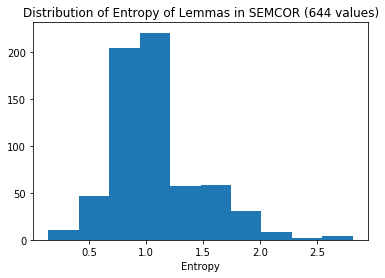

In [112]:
entropy_df = entropy_df[entropy_df['entropy'] != 0]
plt.hist(entropy_df['entropy'])
plt.title("Distribution of Entropy of Lemmas in SEMCOR (644 values)")
plt.xlabel("Entropy")

In [120]:
entropy_df[entropy_df['word'] == 'develop']

,word,pos,entropy
833,develop,v,1.533824
